# 文本预处理 文本就是一个有时序条件的序列

In [1]:
# 对于序列数据处理问题

# 文本是最常见例子之一。 例如，一篇文章可以被简单地看作一串单词序列，甚至是一串字符序列

import collections
import re
from d2l import torch as d2l

In [11]:
# 将数据集读取到由多条文本行组成的列表中去

#@save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  #@save
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
        #不是大小写字母的全部变成空格
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]



lines = read_time_machine()
print(f'# 文本总行数: {len(lines)}')
print(lines[0])
print(lines[10])

# 文本总行数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [12]:
# 将文本序列拆分成一个标记列表

def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    # 检查 token 类型，决定是按单词还是字符进行拆分
    if token == 'word':
        # 如果 token 类型为 'word'，则将每行按空格拆分为单词
        return [line.split() for line in lines]
    elif token == 'char':
        # 如果 token 类型为 'char'，则将每行转换为字符列表
        return [list(line) for line in lines]
    else:
        # 如果 token 类型不符合预期，输出错误信息
        print('错误：未知词元类型：' + token)

# 调用 tokenize 函数并将结果存储在 tokens 变量中
tokens = tokenize(lines,token='word')

# 打印前 11 个词元
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [13]:
# 构建一个字典（词汇表） 用来将字符串类型的标记映射到从0开始的数字索引中
class Vocab:  #@save
    """文本词表"""
    
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        # 初始化词表
        if tokens is None:
            tokens = []  # 如果未提供 tokens，则初始化为空列表
        if reserved_tokens is None:
            reserved_tokens = []  # 如果未提供保留词元，则初始化为空列表

        # 按出现频率统计和排序词元
        counter = count_corpus(tokens)  # 调用 count_corpus 统计词元频率
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)  # 按频率排序
        
        # 初始化 idx_to_token，包括未知词元和保留词元
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        # 填充词表
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break  # 如果出现频率小于 min_freq，则停止添加
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)  # 将 token 添加到 idx_to_token
                self.token_to_idx[token] = len(self.idx_to_token) - 1  # 在 token_to_idx 中记录索引

    def __len__(self):
        # 返回词表的大小
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        # 支持通过索引获取词元的索引
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)  # 如果是单个词元，返回其索引
        return [self.__getitem__(token) for token in tokens]  # 如果是列表或元组，递归获取索引

    def to_tokens(self, indices):
        # 将索引转换为对应的词元
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]  # 如果是单个索引，直接返回对应的词元
        return [self.idx_to_token[index] for index in indices]  # 如果是列表或元组，返回对应的词元列表

    @property
    def unk(self):  # 未知词元的索引为 0
        return 0

    @property
    def token_freqs(self):
        # 返回词元的频率
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens可以是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    # 使用 Counter 统计每个词元的频率
    return collections.Counter(tokens)

In [14]:
# 构建词汇表

vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [16]:
# 将每一个文本转换为一个数字索引表
for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [17]:
# 将所有功能打包到函数之中
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

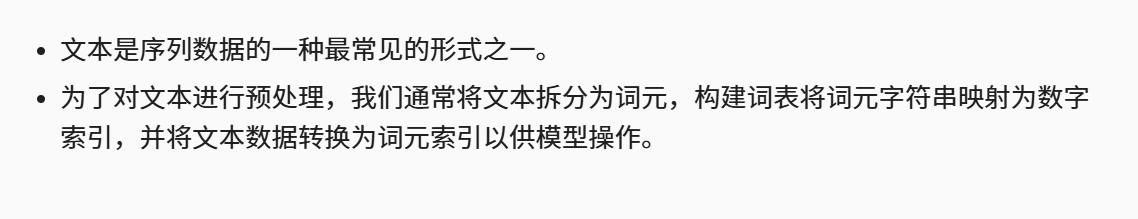